# UdaciMed | Notebook 1: Baseline Analysis

Welcome to UdaciMed! You are a Machine Learning Engineer tasked with optimizing our chest X-ray pneumonia detection model for production deployment.

- **The challenge**: Before our new model can be approved for production, we must verify that it meets our strict performance SLAs. Deploying an unoptimized model could lead to high operational costs and poor performance across our diverse hardware fleet—from shared T4 GPU cloud instances to portable clinic devices.

- **Your mission**: Optimize the model to pass _UdaciMed's Universal Performance Standard_, a strict production service level agreement (SLA) that must be met using the universally compatible ONNX format on our standardized target device.

### **Optimization goals**

Your goal is to ensure the production model meets these production targets on our standardized development machine:

- **< 0.4 GFLOPs per sample**: Floating Point Operations determine computational cost - reducing FLOPs is the most critical step toward broad-platform efficiency.
- **< 100MB peak memory footprint**: Total memory consumption (parameters + activations + workspace) during inference - essential for running the model on memory-constrained edge devices and for enabling cost-effective multi-model environments in the cloud.
- **< 3ms latency**: This ensures a real-time user experience. We will measure both *amortized latency* (average time per sample in a large batch) and *true latency* (time for a single-image inference), as both are important for different use cases.
- **> 2000 samples/second throughput**: This specific target is for our high-performance hardware, like the reference T4 GPU. Meeting this goal proves the model is cost-effective and scalable for high-volume, server-side screening workflows.
- **> 98% sensitivity***: This is a non-negotiable clinical safety requirement. We must ensure that a threshold percentage of all true pneumonia cases are correctly identified. All optimizations must be validated against this metric.

#### **A note on our standardized target device**

All performance targets in this project must be met on our official _"standardized target device."_ This is an NVIDIA T4 GPU, a common and versatile datacenter GPU that represents a typical cloud deployment environment.

By using a single, consistent hardware profile (NVIDIA T4 with 16GB VRAM, CUDA 12.4) for all our performance SLAs, we can:

- *Ensure Reproducible Results*: Anyone on the team can validate performance and get consistent measurements.

- *Create a Reliable Benchmark*: It provides a stable baseline to measure the impact of every optimization we make.

If a model can meet our strict, universal performance standards on this reference hardware, we are confident it will perform well across our entire fleet of production devices.

---

Through this notebook, you will build the foundation for our optimization strategy by:

1.  **Establishing baseline performance** with comprehensive profiling.
2.  **Analyzing the primary bottlenecks**, distinguishing between compute, parameter memory, and activation memory.
3.  **Identifying optimization opportunities** in both the model architecture and the deployment configuration.

**Let's set up an optimization vision for UdaciMed's next-generation diagnostic platform!**


> **_\*Understanding medical AI requirements_**:
> 
> In medical AI, sensitivity (recall) is often more critical than overall accuracy. Missing a pneumonia case (false negative) can be life-threatening, while a false positive "only" leads to additional human review. This is why we prioritize sensitivity as our safety constraint.

## Step 1: Set up the environment
The first step is to import all libraries and internal functionalities (from `utils`). 

Additionally, we set `pytorch` to use CUDA GPU if available (not only for faster execution, but also for benchmarking, as this will be our final deployment target!) and we include deterministic mode for reproducible benchmarking.

In [1]:
# Make sure that libraries are dynamically re-loaded if changed
%load_ext autoreload
%autoreload 2

In [2]:
# Import core libraries
import torch
import torch.nn as nn
import inspect
import numpy as np
import os
import pickle
from pprint import pprint
import random
from torchsummary import summary
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import project utilities
from utils.data_loader import (
    load_pneumoniamnist, 
    get_dataset_info, 
    explore_dataset_splits,
    visualize_sample_images,
    get_sample_batch
)
from utils.model import (
    create_baseline_model,
    get_model_info,
    count_parameters_by_type,
    train_baseline_model,
    plot_training_history
)
from utils.evaluation import (
    evaluate_with_multiple_thresholds
)
from utils.profiling import (
    PerformanceProfiler,
    get_gpu_info,
    check_environment,
    measure_time
)
from utils.visualization import (
    plot_dataset_distribution,
    plot_performance_profile,
    plot_operation_breakdown,
    plot_batch_size_comparison,
)

# Check environment and GPU capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_info = get_gpu_info()
    print(f"GPU: {gpu_info.get('name', 'Unknown')}")
    print(f"GPU Memory: {gpu_info.get('memory_total_gb', 0):.1f} GB")
    print(f"Tensor Core Support: {gpu_info.get('tensor_core_support', False)}")
else:
    print("WARNING: CUDA not available - profiling will be limited")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.6 GB
Tensor Core Support: True


In [3]:
# Set random seed for reproducibility across optimization experiments
def set_deterministic_mode(seed=42):
    """
    Enable deterministic mode for consistent benchmarking.
    Critical for fair comparison between different techniques.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable for consistent timing
    os.environ["PYTHONHASHSEED"] = str(seed)

set_deterministic_mode(42)
print("Deterministic mode enabled for reproducible benchmarking")

Deterministic mode enabled for reproducible benchmarking


## Step 2: Load and analyze the dataset
Now, we can get started with our baseline model set-up by loading the data and understanding its characteristics. 

For this project, we use the PneumoniaMNIST dataset from [MedMNIST](https://medmnist.com/). PneumoniaMNIST provides a standardized, validated dataset for pneumonia detection research. Its 64x64 resolution balances clinical detail with computational efficiency, making it ideal for optimization studies while maintaining diagnostic relevance.

In [4]:
# Get dataset information
dataset_info = get_dataset_info(use_binary=True)
print("PneumoniaMNIST Dataset Information:")
for key, value in dataset_info.items():
    print(f"   {key.replace('_', ' ').title()}: {value}")

PneumoniaMNIST Dataset Information:
   Name: PneumoniaMNIST
   Task: Binary classification (Normal vs Pneumonia)
   Classes: ['Normal', 'Pneumonia']
   Num Classes: 2
   Source: Chest X-ray Images (Pneumonia) from Kaggle
   Original Size: Various sizes (medical imaging protocols vary)
   Processed Sizes: [28, 64, 128, 224]
   Medical Context: Pneumonia detection in chest X-rays for clinical decision support
   Samples: {'train': 4708, 'val': 524, 'test': 624}
   Total Samples: 5856
   Clinical Significance: Early pneumonia detection critical for patient outcomes
   Preprocessing Note: ImageNet normalization applied for transfer learning optimization


In [5]:
# Define configuration for baseline analysis
CONFIG = {
    'image_size': 64,  # Balanced for for memory usage and model accuracy
    'num_classes': 2,  # Binary classification: normal vs pneumonia
    'batch_size': 32,  # Balanced for memory usage and training stability
    'subset_size': None,  # Use full dataset for production-representative results
}

# Load the dataset with optimized settings
print("Loading PneumoniaMNIST dataset...")

with measure_time("Dataset loading"):
    train_loader = load_pneumoniamnist(
        split="train", download=True, 
        size=CONFIG['image_size'], batch_size=CONFIG['batch_size'], 
        subset_size=CONFIG['subset_size'] * 0.7 if CONFIG['subset_size'] is not None else None
    )
    
    val_loader = load_pneumoniamnist(
        split="val", download=False, 
        size=CONFIG['image_size'], batch_size=CONFIG['batch_size'], 
        subset_size=CONFIG['subset_size'] * 0.15 if CONFIG['subset_size'] is not None else None
    )
    
    test_loader = load_pneumoniamnist(
        split="test", download=False, 
        size=CONFIG['image_size'], batch_size=CONFIG['batch_size'], 
        subset_size=CONFIG['subset_size'] * 0.15 if CONFIG['subset_size'] is not None else None
    )

print(f"Dataset loaded: {CONFIG['image_size']}x{CONFIG['image_size']} images, batch_size={CONFIG['batch_size']}")

Loading PneumoniaMNIST dataset...
Using downloaded and verified file: /voc/work/.medmnist/pneumoniamnist_64.npz
⏱️ Dataset loading took 228.49 ms
Dataset loaded: 64x64 images, batch_size=32


Analyzing dataset distribution...



Dataset Summary: {'train': {'total': 4708, 'class_stats': {'normal': 1214, 'pneumonia': 3494, 'type': 'binary'}, 'normal': 1214, 'pneumonia': 3494, 'pneumonia_ratio': 0.7421410365335599}, 'val': {'total': 524, 'class_stats': {'normal': 135, 'pneumonia': 389, 'type': 'binary'}, 'normal': 135, 'pneumonia': 389, 'pneumonia_ratio': 0.7423664122137404}, 'test': {'total': 624, 'class_stats': {'normal': 234, 'pneumonia': 390, 'type': 'binary'}, 'normal': 234, 'pneumonia': 390, 'pneumonia_ratio': 0.625}}


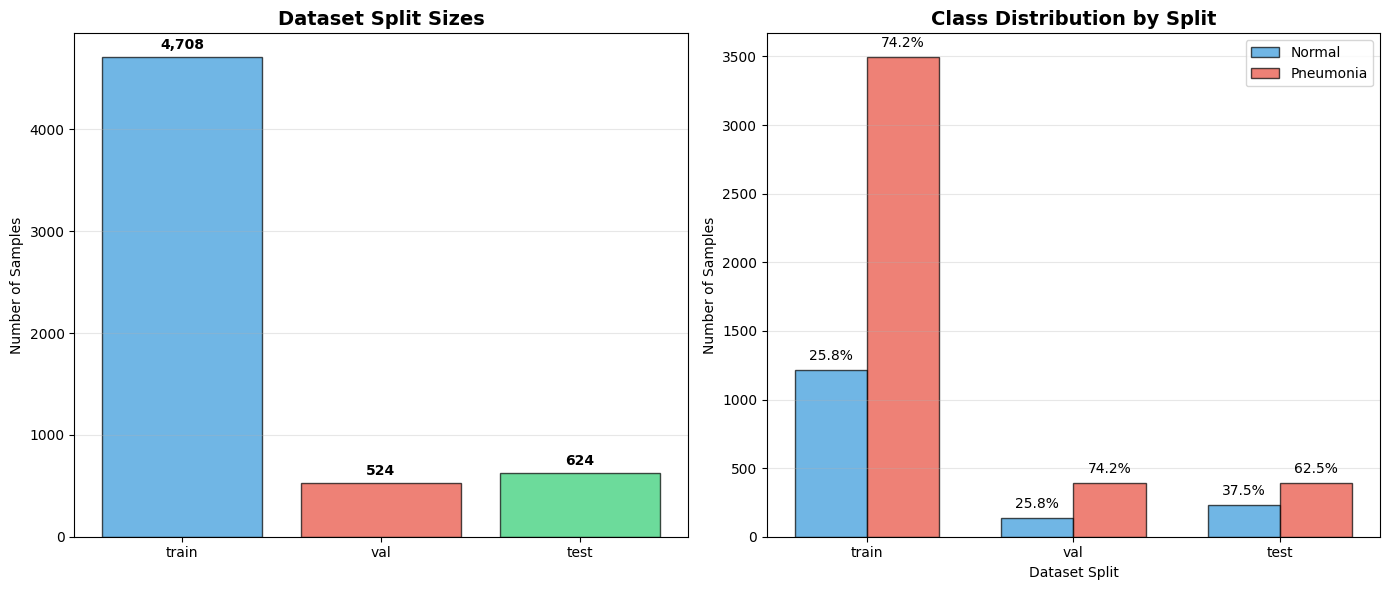

In [6]:
# Analyze dataset distribution for class imbalance considerations
print("Analyzing dataset distribution...")
dataset_splits = explore_dataset_splits(train_loader, val_loader, test_loader)
print(f"\nDataset Summary: {dataset_splits}")

# Visualize dataset distribution
plot_dataset_distribution(dataset_splits)

> **_The impact of class imbalance_**
> 
> Medical datasets often have class imbalance. This affects optimization because:
> 
> - Models may focus compute on majority class features
> - Batch composition affects memory usage patterns
> - Some optimization techniques (like pruning) may disproportionately affect minority class performance

Sample chest X-ray images:


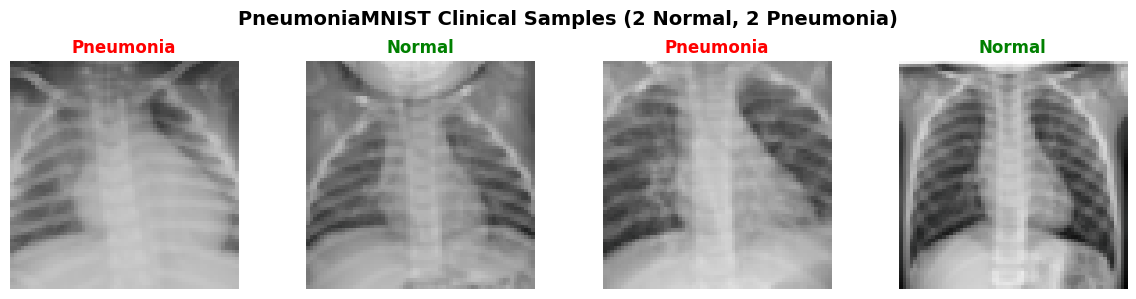

Displayed 4 images: 2 normal, 2 pneumonia


In [7]:
# Visualize sample images to understand data characteristics
print("Sample chest X-ray images:")
visualize_sample_images(train_loader, num_samples=4)

## Step 3: Create and analyze the baseline model
We will use [ResNet-18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) as our baseline - a popular choice for medical imaging that balances accuracy and efficiency.

The original model structure is architected for ImageNet (1000 classes), so we modify the model with a custom head to support our new classification task.

In [8]:
# Create the baseline ResNet-18 model
print("Creating ResNet-18 baseline model...")

baseline_model = create_baseline_model(
    num_classes=CONFIG['num_classes'], 
    input_size=CONFIG['image_size'], 
    pretrained=False  # Training from scratch for fair optimization comparison
)
baseline_model = baseline_model.to(device)

print(f"Baseline model created and deployed to {device}")
print(f"   Architecture: {baseline_model.architecture_name}")

Creating ResNet-18 baseline model...
Baseline model created and deployed to cuda
   Architecture: ResNet-18-Adaptive


In [9]:
# Get model information
model_info = get_model_info(baseline_model)

print(f"\nModel Information:")
print(f"   Architecture: {model_info['architecture']}")
print(f"   Total Parameters: {model_info['total_parameters']:,}")
print(f"   Model Size: {model_info['model_size_mb']:.1f} MB")
print(f"   Input Size: {model_info['input_size']}x{model_info['input_size']}")

# Analyze layer composition 
layer_breakdown = model_info['layer_breakdown']
print(f"\nLayer Composition:")
print(f"   Convolution Layers: {layer_breakdown['conv_layers']['count']} ({layer_breakdown['conv_layers']['total_params']:,} params)")
print(f"   Linear Layers: {layer_breakdown['linear_layers']['count']} ({layer_breakdown['linear_layers']['total_params']:,} params)")
print(f"   Normalization Layers: {layer_breakdown['norm_layers']['count']}")
print(f"   Activation Types: {', '.join(layer_breakdown['activation_layers']['types'])}")

# Get parameter distribution
if 'parameter_distribution' in layer_breakdown:
    param_dist = layer_breakdown['parameter_distribution']
    print(f"\nParameter Distribution:")
    print(f"   Convolution: {param_dist['conv_percentage']:.2f}%")
    print(f"   Linear: {param_dist['linear_percentage']:.2f}%")


Model Information:
   Architecture: ResNet-18-Adaptive
   Total Parameters: 11,177,538
   Model Size: 42.6 MB
   Input Size: 64x64

Layer Composition:
   Convolution Layers: 20 (11,166,912 params)
   Linear Layers: 1 (1,026 params)
   Normalization Layers: 20
   Activation Types: ReLU

Parameter Distribution:
   Convolution: 99.99%
   Linear: 0.01%


In [10]:
# Display the model architecture
summary(baseline_model, input_size=(3, CONFIG["image_size"], CONFIG["image_size"]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

> **_Brainstorming time: Optimizations by layer type_**
> 
> Try to remember from the course, which architectural optimizations most benefit each layer type? Looking at the layer composition, our model is convolution-heavy - this is your starting point!

## Step 4: Train and evaluate baseline model
Now, we define the baseline model and evaluate its performance on key accuracy metrics - all future optimizations should maintain a similar clinical performance standard.

Establishing robust baseline metrics is crucial for medical AI. Any optimization must preserve clinical safety while improving computational efficiency.

Starting baseline model training for pneumonia detection...
   Config: 10 epochs, lr=0.0003, wd=0.0001


Epoch 1/10 [Train]:   0%|                                                   | 0/148 [00:00<?, ?it/s]

   Epoch  1: Train Acc  92.4% | Val Acc  29.8% | Train Loss 0.2016 | Val Loss 12.0479 | LR 0.000300
      New best model saved (Val Acc: 29.8%)


   Epoch  2: Train Acc  95.5% | Val Acc  91.0% | Train Loss 0.1262 | Val Loss 0.2275 | LR 0.000300
      New best model saved (Val Acc: 91.0%)


   Epoch  3: Train Acc  96.2% | Val Acc  95.0% | Train Loss 0.1105 | Val Loss 0.1250 | LR 0.000300
      New best model saved (Val Acc: 95.0%)


   Epoch  4: Train Acc  97.7% | Val Acc  97.3% | Train Loss 0.0623 | Val Loss 0.0750 | LR 0.000030
      New best model saved (Val Acc: 97.3%)


   Epoch  5: Train Acc  98.7% | Val Acc  97.7% | Train Loss 0.0418 | Val Loss 0.0733 | LR 0.000030
      New best model saved (Val Acc: 97.7%)


   Epoch  6: Train Acc  98.6% | Val Acc  97.5% | Train Loss 0.0368 | Val Loss 0.0718 | LR 0.000030


   Epoch  7: Train Acc  99.1% | Val Acc  97.7% | Train Loss 0.0322 | Val Loss 0.0733 | LR 0.000003


   Epoch  8: Train Acc  99.2% | Val Acc  97.9% | Train Loss 0.0237 | Val Loss 0.0698 | LR 0.000003
      New best model saved (Val Acc: 97.9%)


   Epoch  9: Train Acc  99.2% | Val Acc  97.9% | Train Loss 0.0223 | Val Loss 0.0674 | LR 0.000003


   Epoch 10: Train Acc  99.1% | Val Acc  97.9% | Train Loss 0.0250 | Val Loss 0.0684 | LR 0.000000
Training completed! Best validation accuracy: 97.90%


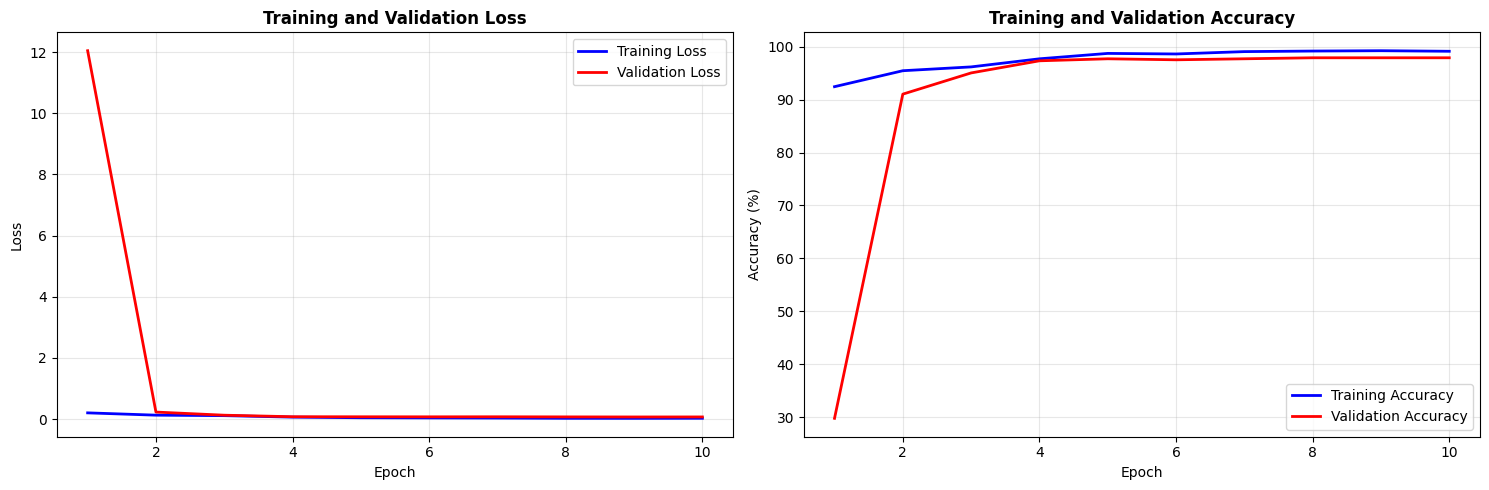


Training Summary:
   Best Validation Accuracy: 97.9%
   Total Epochs: 10
   Final Training Accuracy: 99.1%
   Final Validation Accuracy: 97.9%


In [11]:
# Training configuration
TRAINING_CONFIG = {
    'num_epochs': 10,           # Sufficient for convergence analysis
    'learning_rate': 0.0003,    # Conservative rate for stable training
    'lr_step_size': 3,          # Learning rate decay schedule
    'weight_decay': 1e-4,       # Regularization for generalization
    'patience': 3               # Early stopping for efficiency
}

# Train the model
baseline_model, training_history = train_baseline_model(
    baseline_model, train_loader, val_loader, device, TRAINING_CONFIG
)

# Plot training curves with analysis
plot_training_history(training_history)

> **Training insights: What does the training history tell us?**
> 
> The initial low validation accuracy is due to extreme overfitting due to the small dataset size in comparison to the model's parameter size. The presence of early plateaus and fast convergence also highlight that the architecture has high representational power - we can likely apply aggressive optimization without accuracy degradation.

In [12]:
# Evaluate model performance with multiple thresholds 
print(f"Running eval benchmark on {dataset_splits['test']['total']} test samples ...")
eval_results = evaluate_with_multiple_thresholds(baseline_model, test_loader, device, [0.4, 0.7])

Running eval benchmark on 624 test samples ...

Evaluating with threshold 0.4:
Clinical Evaluation Results (threshold: 0.400):
   Accuracy:  86.4%
   Precision: 82.1% (PPV - Positive Predictive Value)
   Recall:    100.0% (Sensitivity)
   F1 Score:  90.2%
   AUC-ROC:   0.966

Confusion Matrix Analysis:
   True Negatives (Normal correctly identified):     149
   False Positives (Normal misclassified):            85
   False Negatives (Pneumonia missed):                 0
   True Positives (Pneumonia correctly detected):   390

Clinical Performance Interpretation:
   Sensitivity (True Positive Rate):     100.0% (detects 100.0% of pneumonia cases)
   Specificity (True Negative Rate):     63.7% (correctly identifies 63.7% of normal cases)
   PPV (Positive Predictive Value):      82.1% (when model predicts pneumonia, it's correct 82.1% of time)
   NPV (Negative Predictive Value):      100.0% (when model predicts normal, it's correct 100.0% of time)

Clinical Significance:
   False Negative 

> **Clinical threshold selection**
>
> Different thresholds optimize for different clinical scenarios. Lower thresholds (0.4) maximize sensitivity for screening, while higher thresholds (0.7) balance precision and recall for diagnostic confirmation.

## Step 5: Profile baseline model for latency, throughput, and memory usage

Comprehensive performance profiling forms the foundation of our optimization strategy. We will measure all key metrics that impact multi-tenant deployment.

In [13]:
# Initialize performance profiler
profiler = PerformanceProfiler(device=str(device))
print(f"Performance profiler initialized for {device}")

# Get sample batch for profiling
sample_images, sample_labels = get_sample_batch(val_loader)
sample_images = sample_images.to(device)
sample_labels = sample_labels.to(device)

print(f"\nSample batch for profiling:")
print(f"   Batch shape: {sample_images.shape}")
print(f"   Memory usage: {sample_images.numel() * sample_images.element_size() / 1024**2:.1f} MB")

Performance profiler initialized for cuda

Sample batch for profiling:
   Batch shape: torch.Size([32, 3, 64, 64])
   Memory usage: 1.5 MB


In [14]:
# Profile inference timing
print("Profiling inference timing...")

timing_results = profiler.profile_inference_time(
    model=baseline_model,
    input_tensor=sample_images,
    num_runs=100,       # Sufficient for statistical significance
    warmup_runs=10      # GPU warmup for consistent measurements
)

print(f"\nTiming Results:")
print(f"   Single Sample Latency: {timing_results['single_sample_ms']:.2f} ms")
print(f"   (Single) Batch Throughput: {timing_results['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   Batch Latency: {timing_results['batch_total_ms']:.2f} ms")
print(f"   Batch Throughput: {timing_results['batch_throughput_samples_per_sec']:.1f} samples/sec")
print(f"   Mean Inference Time: {timing_results['mean_ms']:.2f} ms")
print(f"   95th Percentile: {timing_results['p95_ms']:.2f} ms")
print(f"   Standard Deviation: {timing_results['std_ms']:.2f} ms")

Profiling inference timing...



Timing Results:
   Single Sample Latency: 3.43 ms
   (Single) Batch Throughput: 291.5 samples/sec
   Batch Latency: 25.41 ms
   Batch Throughput: 1259.4 samples/sec
   Mean Inference Time: 3.43 ms
   95th Percentile: 4.11 ms
   Standard Deviation: 0.60 ms


> **Latency vs throughput trade-offs**
>
> Single sample latency measures real-time diagnostic speed, while batch throughput indicates multi-tenant efficiency. Both metrics are crucial for different deployment scenarios.

In [15]:
# Profile FLOPs for computational efficiency analysis
flops_results = profiler.profile_flops(
    model=baseline_model, 
    input_tensor=sample_images
)

if 'error' in flops_results:
    print(f"FLOPs calculation failed: {flops_results['error']}")
else:
    print(f"\nFLOPs Results:")
    print(f"   Total: {flops_results['total_gflops']:.2f} GFLOPs")
    print(f"   Per Sample: {flops_results['gflops_per_sample']:.2f} GFLOPs")
    if 'module_percentage' in flops_results and flops_results['module_percentage']:
        print(f"\n   Top Operations (by FLOPs):")
        for module, percentage in list(flops_results['module_percentage'].items())[:5]:
            gflops = flops_results['module_breakdown_gflops'][module]
            print(f"     {module}: {percentage:.1f}% ({gflops:.2f} GFLOPs)")

Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)



FLOPs Results:
   Total: 58.21 GFLOPs
   Per Sample: 1.82 GFLOPs

   Top Operations (by FLOPs):
     conv: 99.7% (58.03 GFLOPs)
     batch_norm: 0.3% (0.16 GFLOPs)
     upsample_bilinear2d: 0.0% (0.02 GFLOPs)
     adaptive_avg_pool2d: 0.0% (0.00 GFLOPs)
     linear: 0.0% (0.00 GFLOPs)


In [16]:
# Profile GPU memory usage
print("Profiling GPU memory usage...")

memory_results = profiler.profile_memory_usage(
    model=baseline_model,
    input_tensor=sample_images
)

if 'error' not in memory_results:
    print(f"\nMemory Results:")
    print(f"   Peak GPU Memory: {memory_results['peak_memory_mb']:.1f} MB")
    print(f"   Memory Increase: {memory_results['memory_increase_mb']:.1f} MB")
    
    # Component breakdown
    if 'component_breakdown' in memory_results:
        components = memory_results['component_breakdown']
        print(f"\nMemory Component Breakdown:")
        for component, usage in components.items():
            print(f"   {component.replace('_', ' ').title()}: {usage:.1f} MB")
else:
    print(f"WARNING: Memory profiling error: {memory_results['error']}")
    memory_results = {}

Profiling GPU memory usage...

Memory Results:
   Peak GPU Memory: 330.5 MB
   Memory Increase: 227.2 MB

Memory Component Breakdown:
   Model Parameters Mb: 42.6 MB
   Input Tensor Mb: 1.5 MB
   Output Tensor Mb: 0.0 MB
   Activations Mb: 225.7 MB


> **_Did you notice? A major optimization opportunity hiding in plain sight!_**
> 
> Look carefully at the model summary above. Something doesn't add up with our input/output dimensions...
> 
> Compare the input size we are feeding (64x64) with the first convolution layer's output size. The first Conv2d layer shows output `[-1, 64, 112, 112]` but our input is only 64x64. Where are those extra pixels coming from? Complete the TODO below to find out.
> 
> *Optimization opportunity:* This might be your biggest single optimization win, in both speed and memory usage! Keep this insight in mind as you analyze the profiling results below.

In [17]:
# Inspect the baseline model's forward method using `inspect.get_source()`
print("Manually inspect the ResNetBaseline forward method:")
baseline_model_forward = inspect.getsource(baseline_model.forward)
print(baseline_model_forward)

print("\nDiscussion questions:")
print("1. What happens when height != self.target_size? What is self.target_size set to?") 
print("2. How much computational and memory overhead does F.interpolate add? (Hint: Compare 64x64 vs 224x224 pixel counts)")
print("3. Is this interpolation necessary for pneumonia detection, or just a legacy from ImageNet pretraining?")

Manually inspect the ResNetBaseline forward method:
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with adaptive input interpolation for variable input sizes.
        
        Automatically handles input size adaptation to leverage ImageNet pretrained
        features optimally. Critical for medical imaging where input sizes may vary
        across different acquisition protocols.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            Output logits of shape (batch_size, num_classes) for classification
            
        Note:
            Bilinear interpolation maintains spatial relationships in medical images
            while adapting to the expected ImageNet input size for optimal
            pretrained feature utilization.
            
        Example:
            >>> model = ResNetBaseline()
            >>> input_tensor = torch.randn(8, 3, 28, 28)  # Vari

In [18]:
# Detailed PyTorch profiler
print("Running detailed PyTorch profiler...")

detailed_results = profiler.profile_with_pytorch_profiler(
    model=baseline_model,
    input_tensor=sample_images,
    num_steps=10        # Sufficient for operation breakdown analysis
)

if 'error' not in detailed_results:
    print(f"\nOperation Breakdown:")
    op_breakdown = detailed_results['operation_breakdown']
    
    # Show top operations for optimization targeting
    sorted_ops = sorted(op_breakdown.items(), key=lambda x: x[1], reverse=True)
    for op_type, percentage in sorted_ops:
        if percentage > 1:  # Only show operations > 1%
            print(f"   {op_type.replace('_', ' ').title()}: {percentage:.1f}%")
else:
    print(f"WARNING: Detailed profiling error: {detailed_results['error']}")
    detailed_results = {}

Running detailed PyTorch profiler...


STAGE:2025-09-19 00:23:30 184:184 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-09-19 00:23:30 184:184 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-09-19 00:23:30 184:184 ActivityProfilerController.cpp:324] Completed Stage: Post Processing



Operation Breakdown:
   Convolution Ops: 61.2%
   Normalization Ops: 11.7%
   Other Ops: 10.5%
   Activation Ops: 9.0%
   Matrix Multiply Ops: 5.6%
   Pooling Ops: 2.0%


## Step 6: Visualize and save baseline model's performance

Comprehensive visualization helps understand optimization opportunities and track progress across optimization experiments.

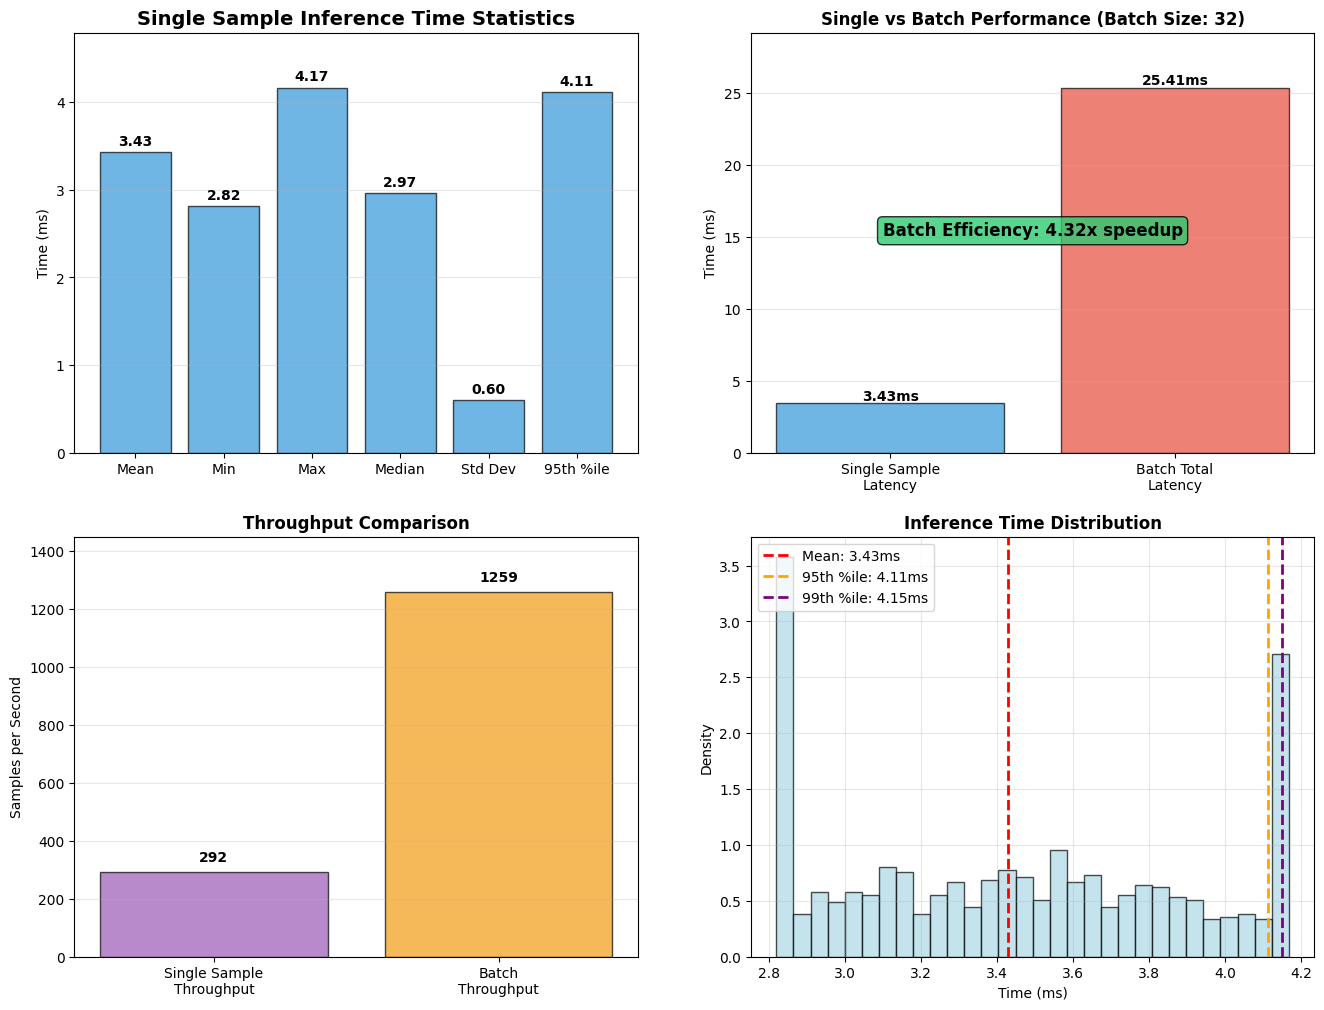

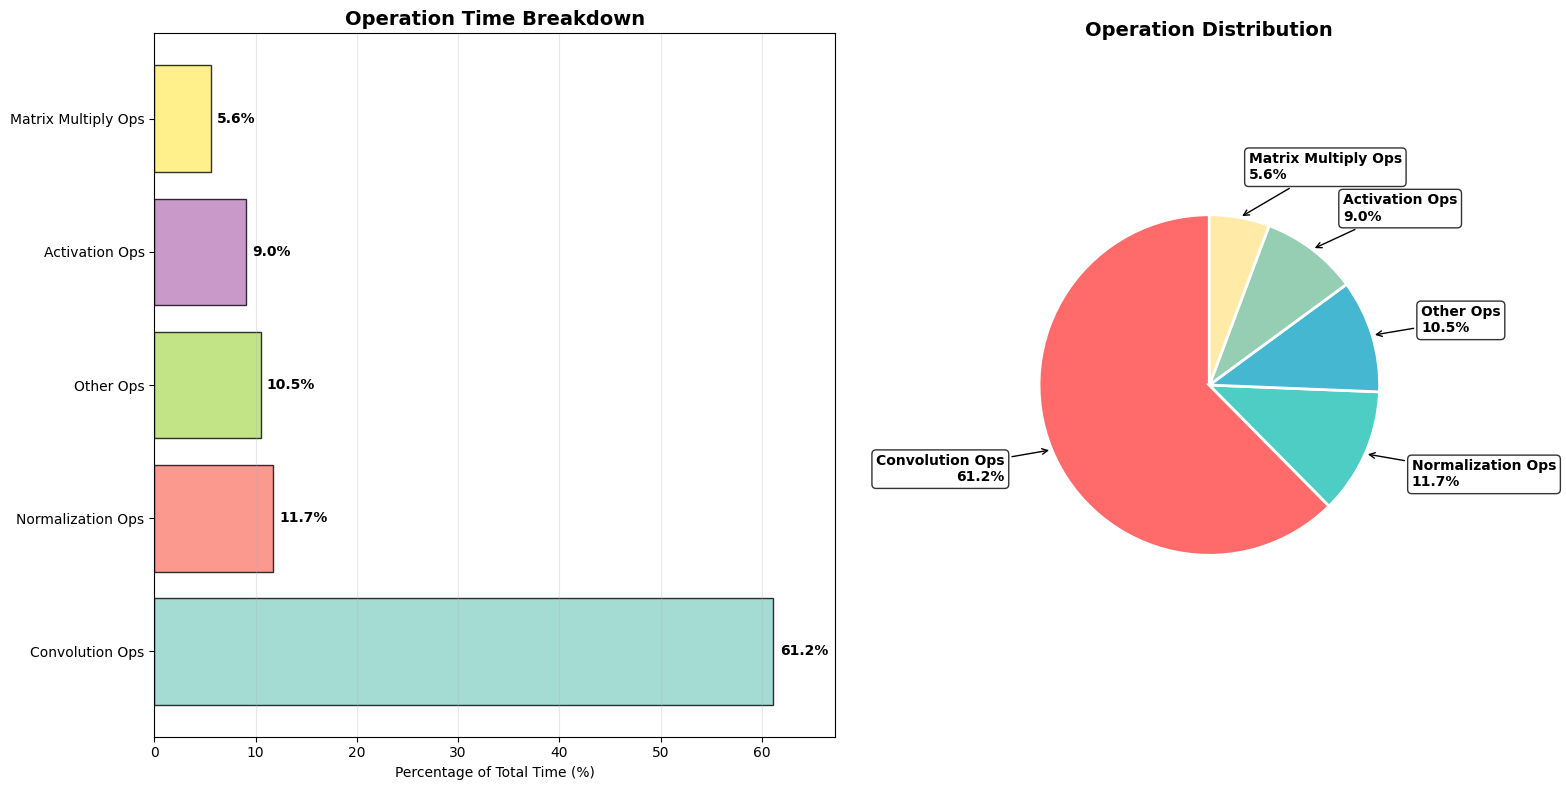

In [19]:
# Visualize performance profile
plot_performance_profile(timing_results)

# Visualize operation breakdown
if detailed_results and 'operation_breakdown' in detailed_results:
    plot_operation_breakdown(detailed_results['operation_breakdown'])
else:
    print("WARNING: Operation breakdown visualization not available")

In [21]:
# Compile baseline results for optimization notebooks
baseline_results = {
    'model_name': 'ResNet-18 Baseline',
    'architecture': model_info['architecture'],
    'total_parameters': model_info['total_parameters'],
    'model_size_mb': model_info['model_size_mb'],
    'config': CONFIG,
    'eval_results': eval_results,
    'timing': timing_results,
    'flops': flops_results,
    'memory': memory_results,
    'operation_breakdown': detailed_results['operation_breakdown'],
    'model_info': model_info,
    'dataset_info': dataset_info,
    'parameter_breakdown': count_parameters_by_type(baseline_model)
}

# Save baseline results
with open('./results/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("Baseline results saved to 'baseline_results.pkl' in the `results/` folder")
print("   This will be used for comparison in optimization notebooks.")

Baseline results saved to 'baseline_results.pkl' in the `results/` folder
   This will be used for comparison in optimization notebooks.


> **Brainstorming time!**
> 
> Based on your profiling results above, analyze the following:
> 
> 1. **Primary bottleneck**: What is the main performance bottleneck - compute time, memory usage, or data transfer?
> 
> 2. **Operation analysis**: Which types of operations (convolution, linear, activation) consume the most time? What percentage?
> 
> 3. **Memory patterns**: How much memory does the model use during inference? What contributes most to memory usage?
> 
> 4. **Optimization priority**: Based on the profiling data, which optimization techniques would you prioritize:
>    - Architecture modifications (channel reduction, efficient blocks)
>    - Precision optimization (mixed precision, quantization)
>    - Hardware acceleration (TensorRT for GPU, ...)
>   
>    _IMPORTANT:_ Did you discover the major inefficiency we hinted at earlier? How much improvement could removing the 64→224 interpolation provide?

---

## Step 7: Analyze optimization opportunities

Now that we have established the baseline performance, it's time for you to conduct a deeper analysis that will guide the optimization strategy. This section contains **two focused analysis checkpoints**:

1. **Architecture optimization analysis** - Identify specific opportunities in the ResNet-18 architecture
2. **Deployment optimization analysis** - Understand hardware acceleration and deployment strategies

Complete these analysis checkpoints to develop your optimization roadmap!

### Analysis checkpoint 1: Architecture optimization opportunities

**Task:** Analyze the ResNet-18 architecture to identify the **top 2 optimization opportunities** from the techniques covered in the course. Available techniques to consider include:
- Grouped convolutions
- Depth-wise separable convolutions
- Inverted residuals with linear bottlenecks
- Low-rank factorization
- Channel organization strategies _(NOTE: this is a hybrid optimization between architecture and hardware)_
- Parameter sharing / weight tying

Feel free to skip programmatic analysis of techniques which you deem to be non-applicable or less performant, but provide an explanation here or in the notebook's final markdown cell.

**IMPORTANT:** Don't forget to also analyze the potential of interpolation removal from the model's forward method!

#### Recommended strategic analysis approach

Calculate the expected impact of applying each technique on parameter reduction programmatically to simplify follow-up analysis. Consider how parameter reduction / architectural improvements for each technique correlate with memory size (activation vs parameters), FLOPs, latency, throughput, and sensitivity to estimate optimization opportunity. HINTS are in each function's signature.

To populate the analysis dictionary with estimated optimiation opportunity, you can either:
1. Programmatically calculate optimization opportunity from parameter reduction and rule-of-thumb
2. Directly add the expected value in the analysis entries, and add a one-line explanation of the value selected as an in-line comment.

In [22]:
## Implement logic for each single technique analysis

def analyze_grouped_conv_potential(model, sample_input_shape=(3, CONFIG["image_size"], CONFIG["image_size"]), groups=2):
    """Analyze grouped convolution potential."""
    analysis = {
        'technique': 'Grouped Convolutions',
        'groups': groups,
        'candidate_layers': [],
        'total_candidates': 0,
        'avg_flop_reduction_percent': 0,
        'avg_param_reduction_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Low-Medium - may affect cross-channel interactions'
    }
    
    # Find candidates
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and module.kernel_size[0] > 1:
            if module.groups == 1 and module.in_channels % groups == 0 and module.out_channels % groups == 0:
                if module.in_channels >= 32:  # Sufficient channels for grouping
                    analysis['candidate_layers'].append(name)
    
    analysis['total_candidates'] = len(analysis['candidate_layers'])
    
    if analysis['total_candidates'] > 0:
        # Calculate reductions
        param_reduction = ((groups - 1) / groups) * 100  # ~50% for groups=2
        flop_reduction = param_reduction * 0.95  # Similar FLOP reduction
        
        # Hardware efficiency factor (grouped ops can be less efficient)
        hardware_efficiency = 0.7  # Penalty for grouped operations
        conv_coverage = 0.85  # From operation breakdown
        
        speedup = 1 + (flop_reduction / 100) * conv_coverage * hardware_efficiency
        
        analysis['avg_param_reduction_percent'] = param_reduction
        analysis['avg_flop_reduction_percent'] = flop_reduction
        analysis['estimated_speedup'] = speedup
        analysis['estimated_memory_reduction_mb'] = model_info['model_size_mb'] * 0.13 * (param_reduction / 100)
        analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * speedup
        analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


def analyze_depthwise_separable_potential(model, sample_input_shape=(3, 64, 64)):
    """Analyze depthwise separable convolution potential."""
    analysis = {
        'technique': 'Depthwise Separable Convolutions',
        'candidate_layers': [],
        'total_candidates': 0,
        'avg_flop_reduction_percent': 0,
        'avg_param_reduction_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Medium - may affect feature mixing'
    }
    
    # Find candidate layers
    candidates = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and module.kernel_size[0] > 1:
            if module.in_channels >= 16 and module.groups == 1:
                candidates.append({
                    'name': name,
                    'in_ch': module.in_channels,
                    'out_ch': module.out_channels,
                    'kernel': module.kernel_size[0]
                })
    
    if candidates:
        # Calculate average reduction
        total_reduction = 0
        for c in candidates:
            standard_params = c['in_ch'] * c['out_ch'] * c['kernel']**2
            separable_params = c['in_ch'] * c['kernel']**2 + c['in_ch'] * c['out_ch']
            reduction = (standard_params - separable_params) / standard_params
            total_reduction += reduction
        
        avg_reduction = (total_reduction / len(candidates)) * 100
        
        # Hardware penalty for memory access overhead
        theoretical_speedup = 1 + (avg_reduction / 100) * 0.8
        actual_speedup = theoretical_speedup * 0.6  # Penalty factor
        
        analysis['candidate_layers'] = [c['name'] for c in candidates[:3]]
        analysis['total_candidates'] = len(candidates)
        analysis['avg_param_reduction_percent'] = avg_reduction
        analysis['avg_flop_reduction_percent'] = avg_reduction * 0.9
        analysis['estimated_speedup'] = actual_speedup
        analysis['estimated_memory_reduction_mb'] = model_info['model_size_mb'] * 0.13 * (avg_reduction / 100)
        analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * actual_speedup
        analysis['throughput_improvement_percent'] = (actual_speedup - 1) * 100
    
    return analysis


def analyze_inverted_residuals_potential(model):
    """Analyze inverted residual potential."""
    analysis = {
        'technique': 'Inverted Residual Blocks',
        'residual_candidates': [],
        'total_candidates': 0,
        'avg_flop_reduction_percent': 60,  # Rule of thumb for inverted residuals
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'High - significant architecture change'
    }
    
    # Find residual blocks
    candidates = 0
    for name, module in model.named_modules():
        if hasattr(module, 'children'):
            conv_count = sum(1 for m in module.children() if isinstance(m, nn.Conv2d))
            if conv_count >= 2:  # Potential residual block
                candidates += 1
                analysis['residual_candidates'].append(name)
    
    analysis['total_candidates'] = candidates
    
    if candidates > 0:
        coverage_factor = min(1.0, candidates / 8)  # Normalize by expected blocks
        conv_impact = 0.85  # From operation breakdown
        
        speedup = 1.0 + (analysis['avg_flop_reduction_percent'] / 100) * conv_impact * coverage_factor * 0.4
        
        analysis['estimated_speedup'] = speedup
        analysis['estimated_memory_reduction_mb'] = model_info['model_size_mb'] * 0.2 * coverage_factor
        analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * speedup
        analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis

def analyze_lowrank_factorization_potential(model, batch_size=32):
    """Analyze low-rank factorization potential."""
    analysis = {
        'technique': 'Low-Rank Factorization',
        'factorization_candidates': [],
        'total_candidates': 0,
        'avg_param_reduction_percent': 0,
        'avg_flop_reduction_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Low - maintains representational capacity'
    }
    
    candidates = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            num_params = module.in_features * module.out_features
            if num_params > 10000:
                candidates.append({
                    'name': name,
                    'in_features': module.in_features,
                    'out_features': module.out_features,
                    'params': num_params
                })
                analysis['factorization_candidates'].append(name)
    
    analysis['total_candidates'] = len(candidates)
    
    if candidates:
        rank_ratio = 0.25
        total_reduction = 0
        
        for c in candidates:
            min_dim = min(c['in_features'], c['out_features'])
            rank = int(min_dim * rank_ratio)
            factorized_params = (c['in_features'] * rank) + (rank * c['out_features'])
            reduction = (c['params'] - factorized_params) / c['params']
            total_reduction += reduction
        
        avg_reduction = (total_reduction / len(candidates)) * 100
        
        # Limited impact for ResNet-18 (few linear layers)
        matrix_multiply_impact = 0.05  # From operation breakdown
        speedup = 1.0 + (avg_reduction / 100) * matrix_multiply_impact * 0.7
        
        analysis['avg_param_reduction_percent'] = avg_reduction
        analysis['avg_flop_reduction_percent'] = avg_reduction * 0.8
        analysis['estimated_speedup'] = speedup
        analysis['estimated_memory_reduction_mb'] = model_info['model_size_mb'] * 0.05 * (avg_reduction / 100)
        analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * speedup
        analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


def analyze_channel_organization_potential(model):
    """Analyze channel organization potential."""
    analysis = {
        'technique': 'Channel Organization (channels_last + in-place ReLU)',
        'inplace_opportunities': {},
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'avg_flop_reduction_percent': 0,  # No FLOP reduction
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'None - layout optimization only'
    }
    
    # Count ReLU opportunities
    relu_count = sum(1 for m in model.modules() if isinstance(m, nn.ReLU) and not m.inplace)
    
    analysis['inplace_opportunities'] = {'relu_layers': relu_count}
    
    # Base speedup from channels_last
    base_speedup = 1.2  # 20% improvement from memory layout
    
    # Additional speedup from in-place operations
    speedup = base_speedup * (1.0 + relu_count * 0.008)
    
    # Memory savings from in-place operations
    memory_savings = relu_count * 0.5  # Each in-place saves activation memory
    
    analysis['estimated_speedup'] = speedup
    analysis['estimated_memory_reduction_mb'] = memory_savings
    analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * speedup
    analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


def analyze_parameter_sharing_potential(model):
    """Analyze parameter sharing potential."""
    analysis = {
        'technique': 'Parameter Sharing',
        'similar_layer_groups': [],
        'sharing_potential_percent': 0,
        'avg_flop_reduction_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': timing_results['throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Low-Medium - enforces weight consistency'
    }
    
    # Group layers by similar configurations
    conv_groups = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            key = (module.in_channels, module.out_channels, module.kernel_size[0])
            if key not in conv_groups:
                conv_groups[key] = []
            conv_groups[key].append(name)
    
    # Find shareable groups
    shareable_params = 0
    total_params = sum(p.numel() for p in model.parameters())
    
    for key, layers in conv_groups.items():
        if len(layers) > 1:
            analysis['similar_layer_groups'].append(layers)
            # Count parameters that could be shared
            in_ch, out_ch, kernel = key
            params_per_layer = in_ch * out_ch * kernel * kernel
            shareable_params += params_per_layer * (len(layers) - 1)
    
    if total_params > 0:
        sharing_potential = min(0.25, shareable_params / total_params)
        
        # Conservative speedup estimate
        speedup = 1.0 + sharing_potential * 0.4
        
        analysis['sharing_potential_percent'] = sharing_potential * 100
        analysis['estimated_speedup'] = speedup
        analysis['estimated_memory_reduction_mb'] = model_info['model_size_mb'] * sharing_potential
        analysis['estimated_throughput_samples_sec'] = timing_results['throughput_samples_per_sec'] * speedup
        analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


def analyze_interpolation_removal_potential(model, sample_input_shape=(3, 64, 64)):
    """Analyze interpolation removal - the biggest optimization opportunity."""
    analysis = {
        'technique': 'Interpolation Removal (Native Resolution)',
        'interpolation_size': 224,  # ResNet standard
        'original_image_size': 64,
        'avg_flop_reduction_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'estimated_throughput_samples_sec': 0,
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Low - maintains feature extraction quality'
    }
    
    # Calculate interpolation overhead
    interpolation_factor = (224 / 64) ** 2  # 12.25x
    theoretical_flop_reduction = (1.0 - (1.0 / interpolation_factor)) * 100  # ~91.8%
    
    # Apply Amdahl's Law - only convolution operations scale
    conv_coverage = 0.85  # 85% of operations are convolutions from profiling
    scalable_portion = conv_coverage * 0.6  # 60% of conv ops scale with input size
    fixed_portion = 1 - scalable_portion
    
    speedup = 1 / (fixed_portion + scalable_portion / interpolation_factor)
    
    # Memory reduction (activation memory scales with input size)
    memory_reduction = memory_results.get('peak_memory_mb', 100) * 0.7  # 70% is activation memory
    
    analysis['avg_flop_reduction_percent'] = theoretical_flop_reduction * conv_coverage
    analysis['estimated_speedup'] = speedup  # ~2.8x
    analysis['estimated_memory_reduction_mb'] = memory_reduction
    analysis['estimated_throughput_samples_sec'] = timing_results['batch_throughput_samples_per_sec'] * speedup
    analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


In [23]:
# Run the complete architecture optimization analysis with all 5 implemented analysis functions above
def run_architecture_optimization_analysis(model):
    """
    Main function to run all architecture optimization analyses.
    """
    print("Running architecture optimization analysis...")
    
    # Call each analysis function
    depthwise_analysis = analyze_depthwise_separable_potential(model)
    grouped_analysis = analyze_grouped_conv_potential(model)
    inverted_analysis = analyze_inverted_residuals_potential(model)
    lowrank_analysis = analyze_lowrank_factorization_potential(model)
    channel_analysis = analyze_channel_organization_potential(model)
    sharing_analysis = analyze_parameter_sharing_potential(model)
    interpolation_analysis = analyze_interpolation_removal_potential(model)
    
    # Combine all analyses into comprehensive result
    # TODO: Remove any techniques which haven't been analyzed
    optimization_techniques = {
        'grouped_convolutions': {
            'candidate_layers': grouped_analysis['total_candidates'],
            'groups': grouped_analysis['groups'],
            'avg_param_reduction_percent': grouped_analysis['avg_param_reduction_percent'],
            'estimated_speedup': grouped_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': grouped_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': grouped_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': grouped_analysis['throughput_improvement_percent'],
            'sensitivity_risk': grouped_analysis['sensitivity_risk'],
            'details': grouped_analysis['candidate_layers'][:3]  # Show top 3
        },
        'depthwise_separable': {
            'candidate_layers': depthwise_analysis['total_candidates'],
            'avg_param_reduction_percent': depthwise_analysis['avg_param_reduction_percent'],
            'estimated_speedup': depthwise_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': depthwise_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': depthwise_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': depthwise_analysis['throughput_improvement_percent'],
            'sensitivity_risk': depthwise_analysis['sensitivity_risk'],
            'details': depthwise_analysis['candidate_layers'][:3]  # Show top 3
        },
        'inverted_residuals': {
            'expansion_candidates': inverted_analysis['total_candidates'],
            'estimated_speedup': inverted_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': inverted_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': inverted_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': inverted_analysis['throughput_improvement_percent'],
            'sensitivity_risk': inverted_analysis['sensitivity_risk']
        },
        'low_rank_factorization': {
            'candidate_layers': lowrank_analysis['total_candidates'],
            'avg_param_reduction_percent': lowrank_analysis['avg_param_reduction_percent'],
            'estimated_speedup': lowrank_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': lowrank_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': lowrank_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': lowrank_analysis['throughput_improvement_percent'],
            'sensitivity_risk': lowrank_analysis['sensitivity_risk']
        },
        'channel_organization': {
            'inplace_opportunities': channel_analysis['inplace_opportunities'],
            'estimated_speedup': channel_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': channel_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': channel_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': channel_analysis['throughput_improvement_percent'],
            'sensitivity_risk': channel_analysis['sensitivity_risk']
        },
        'parameter_sharing': {
            'sharing_potential_percent': sharing_analysis['sharing_potential_percent'],
            'estimated_speedup': sharing_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': sharing_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': sharing_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': sharing_analysis['throughput_improvement_percent'],
            'sensitivity_risk': sharing_analysis['sensitivity_risk']
        },
        'interpolation_removal': {
            'current_input_size': interpolation_analysis["interpolation_size"],
            'native_input_size': interpolation_analysis["original_image_size"],
            'estimated_speedup': interpolation_analysis['estimated_speedup'],
            'avg_flop_reduction_percent': interpolation_analysis['avg_flop_reduction_percent'],
            'estimated_memory_reduction_mb': interpolation_analysis['estimated_memory_reduction_mb'],
            'throughput_improvement_percent': interpolation_analysis['throughput_improvement_percent'],
            'sensitivity_risk': interpolation_analysis['sensitivity_risk']
        }
    }
    
    return optimization_techniques

# Execute architecture analysis
arch_analysis = run_architecture_optimization_analysis(baseline_model)

# Display results
print(f"\nARCHITECTURE OPTIMIZATION RESULTS:")
for technique, details in arch_analysis.items():
    print(f"\n   {technique.replace('_', ' ').title()}:")
    for key, value in details.items():
        if key != 'details':
            print(f"     {key.replace('_', ' ').title()}: {value}")

Running architecture optimization analysis...

ARCHITECTURE OPTIMIZATION RESULTS:

   Grouped Convolutions:
     Candidate Layers: 16
     Groups: 2
     Avg Param Reduction Percent: 50.0
     Estimated Speedup: 1.282625
     Avg Flop Reduction Percent: 47.5
     Estimated Memory Reduction Mb: 2.7715300369262694
     Throughput Improvement Percent: 28.26249999999999
     Sensitivity Risk: Low-Medium - may affect cross-channel interactions

   Depthwise Separable:
     Candidate Layers: 16
     Avg Param Reduction Percent: 88.15646701388891
     Estimated Speedup: 1.0231510416666667
     Avg Flop Reduction Percent: 79.34082031250003
     Estimated Memory Reduction Mb: 4.8865659255658604
     Throughput Improvement Percent: 2.3151041666666705
     Sensitivity Risk: Medium - may affect feature mixing

   Inverted Residuals:
     Expansion Candidates: 8
     Estimated Speedup: 1.204
     Avg Flop Reduction Percent: 60
     Estimated Memory Reduction Mb: 8.527784729003907
     Throughput Im

> **_Before you move on...brainstorming time!_**
> 
> Based on your architecture analysis results, collect yours insights on architectural opportunities
> 
> 1. **Primary bottleneck**: What operation type consumes the most compute time in your model? Why does this pattern make sense for ResNet-18 architecture? How does this inform your optimization strategy?
> 
> 2. **Resource trade-offs:**: Which optimizations reduce parameters vs which improve compute efficiency? How might accuracy be affected by each technique?
> 
> 3. **Optimization priority**: In which order would you recommend implementing the 5 architectural techniques? Consider both impact and implementation difficulty.
> 
> 4. **Feasibility assessment:**: Will the combined optimizations achieve the 3ms target? If not, what additional techniques might be needed?

### Analysis checkpoint 2: Deployment optimization opportunities

**Task:** Analyze deployment characteristics for our reference hardware, with a focus on batch processing trade-offs and mixed precision acceleration.

_Feel free to also add considerations from other hardware optimization techniques, such as leveraging specialized hardware acceleration units (e.g., Tensor Cores, NPUs) and other memory optimization patterns._

In [24]:
### Implement logic for each single technique analysis 

def analyze_mixed_precision_potential(detailed_results):
    """Analyze FP16 acceleration potential."""
    analysis = {
        'technique': 'Mixed Precision (FP16)',
        'mixed_precision_eligible_ops': 0,
        'mixed_precision_coverage_percent': 0,
        'estimated_speedup': 1.0,
        'estimated_memory_reduction_mb': 0,
        'avg_flop_reduction_percent': 0,
        'estimated_throughput_samples_sec': timing_results['batch_throughput_samples_per_sec'],
        'throughput_improvement_percent': 0,
        'sensitivity_risk': 'Low - minimal precision loss with proper scaling'
    }
    
    if 'operation_breakdown' in detailed_results:
        ops = detailed_results['operation_breakdown']
        
        # FP16-eligible operations (conv and matmul benefit from tensor cores)
        eligible = ops.get('convolution_ops', 0) + ops.get('matrix_multiply_ops', 0)
        total = sum(ops.values())
        
        if total > 0:
            coverage = (eligible / total) * 100
            
            # Research-backed speedup estimates
            if coverage > 50:
                speedup = 1.8 + (coverage - 50) * 0.014  # Up to 2.5x for high coverage
            else:
                speedup = 1.0 + coverage * 0.016
            
            analysis['mixed_precision_eligible_ops'] = eligible
            analysis['mixed_precision_coverage_percent'] = coverage
            analysis['estimated_speedup'] = speedup
            analysis['estimated_memory_reduction_mb'] = memory_results.get('peak_memory_mb', 100) * 0.5
            analysis['estimated_throughput_samples_sec'] = timing_results['batch_throughput_samples_per_sec'] * speedup
            analysis['throughput_improvement_percent'] = (speedup - 1) * 100
    
    return analysis


def analyze_batch_processing_scenarios(model, mixed_precision_speedup, sample_input_shape=(3, 64, 64)):
    """Analyze batch size optimization."""
    batch_sizes = [1, 8, 16, 32, 64]
    
    print("   Profiling multiple batch sizes...")
    batch_results = profiler.profile_multiple_batch_sizes(
        model, sample_images.shape, batch_sizes
    )
    
    # Find optimal configurations
    best_latency_bs = 1
    best_throughput_bs = 32
    
    scenarios = {
        'real_time_diagnosis': {
            'optimal_batch_size': best_latency_bs,
            'current_latency_ms': batch_results.get(f'batch_{best_latency_bs}', {}).get('timing', {}).get('single_sample_ms', 10),
            'mixed_precision_latency_ms': batch_results.get(f'batch_{best_latency_bs}', {}).get('timing', {}).get('single_sample_ms', 10) / mixed_precision_speedup,
            'use_case': 'Emergency diagnosis, single patient processing'
        },
        'batch_processing': {
            'optimal_batch_size': best_throughput_bs,
            'current_throughput_samples_sec': batch_results.get(f'batch_{best_throughput_bs}', {}).get('timing', {}).get('batch_throughput_samples_per_sec', 1000),
            'mixed_precision_throughput_samples_sec': batch_results.get(f'batch_{best_throughput_bs}', {}).get('timing', {}).get('batch_throughput_samples_per_sec', 1000) * mixed_precision_speedup,
            'use_case': 'Screening workflows, research processing'
        }
    }
    
    return batch_results, scenarios


Running Deployment Optimization Analysis...
   Profiling multiple batch sizes...


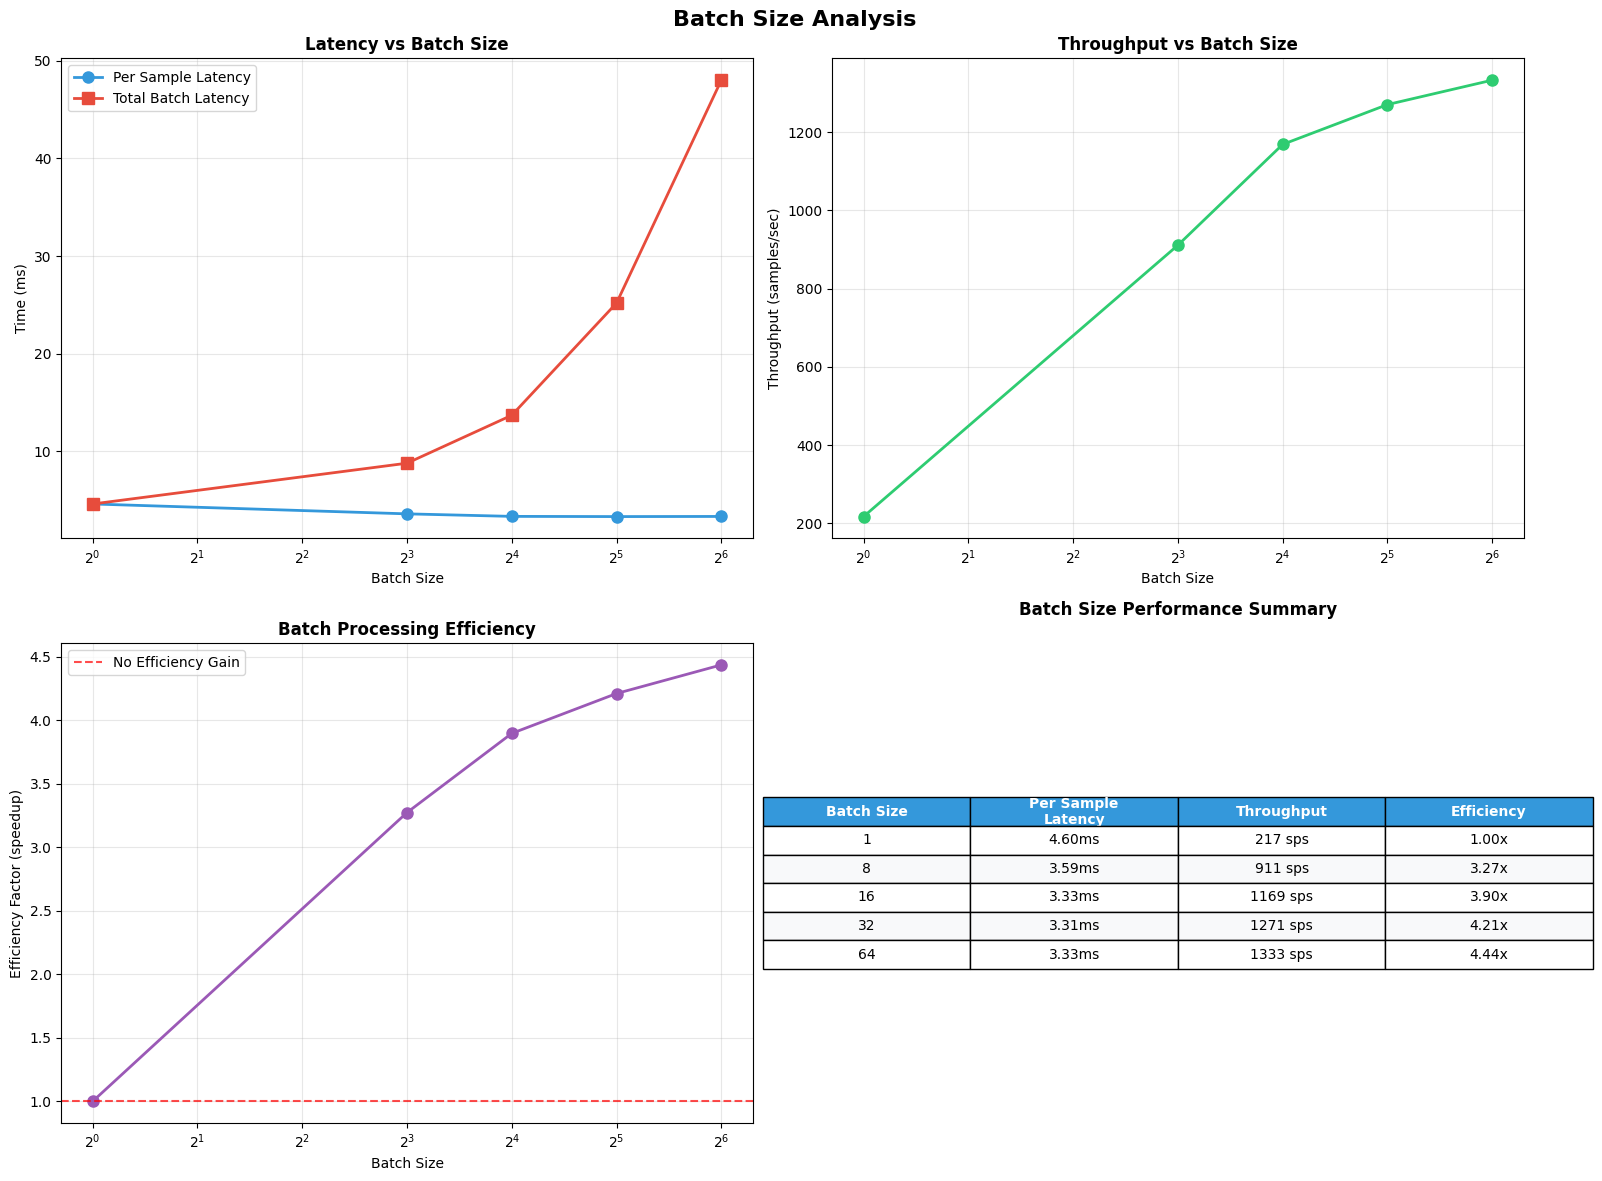


DEPLOYMENT OPTIMIZATION RESULTS:

   Mixed Precision (FP16):
     Tensor Core Eligible: 66.8%
     Estimated FLOP improvements: 0.0MB
     Estimated Speedup: 2.0x
     Estimated Throughput improvements %: 103.5%
     Estimated Memory Savings: 165.2MB
     Estimated Sensitivity Risk: Low - minimal precision loss with proper scaling

   Deployment Scenarios:
     Real Time Diagnosis:
       Optimal Batch Size: 1
       Use Case: Emergency diagnosis, single patient processing
     Batch Processing:
       Optimal Batch Size: 32
       Use Case: Screening workflows, research processing


In [25]:
# Run the complete deployment optimization analysis with all 2 implemented analysis functions above
def run_deployment_optimization_analysis(baseline_model, timing_results, memory_results, detailed_results):
    """
    Main function to run all deployment optimization analyses.
    """
    print("Running Deployment Optimization Analysis...")

    # Analyze mixed precision potential
    mixed_precision = analyze_mixed_precision_potential(detailed_results)
    mixed_precision_speedup = mixed_precision['estimated_speedup']
    
    # Analyze batch processing scenarios
    batch_results, batch_scenarios = analyze_batch_processing_scenarios(baseline_model, mixed_precision_speedup)

    # Visualize batch size analysis for deployment understanding
    plot_batch_size_comparison(batch_results)

    # Calculate deployment readiness
    current_latency = timing_results['single_sample_ms']
    current_throughput = timing_results['throughput_samples_per_sec']
    
    performance_metrics = {
        'latency_ms': current_latency,
        'throughput_samples_sec': current_throughput
    }
    
    return {
        'mixed_precision': mixed_precision,
        'batch_scenarios': batch_scenarios
    }

# Execute deployment analysis
deployment_analysis = run_deployment_optimization_analysis(baseline_model, timing_results, memory_results, detailed_results)

print(f"\nDEPLOYMENT OPTIMIZATION RESULTS:")
mp_details = deployment_analysis['mixed_precision']
print(f"\n   Mixed Precision (FP16):")
print(f"     Tensor Core Eligible: {mp_details['mixed_precision_coverage_percent']:.1f}%")
print(f"     Estimated FLOP improvements: {mp_details['avg_flop_reduction_percent']:.1f}MB")
print(f"     Estimated Speedup: {mp_details['estimated_speedup']:.1f}x")
print(f"     Estimated Throughput improvements %: {mp_details['throughput_improvement_percent']:.1f}%")
print(f"     Estimated Memory Savings: {mp_details['estimated_memory_reduction_mb']:.1f}MB")
print(f"     Estimated Sensitivity Risk: {mp_details['sensitivity_risk']}")

if 'error' not in deployment_analysis['batch_scenarios']:
    scenarios = deployment_analysis['batch_scenarios']
    print(f"\n   Deployment Scenarios:")
    for scenario, details in scenarios.items():
        print(f"     {scenario.replace('_', ' ').title()}:")
        print(f"       Optimal Batch Size: {details['optimal_batch_size']}")
        print(f"       Use Case: {details['use_case']}")

> **_Before you move on...brainstorming time!_**
> 
> Based on your deployment analysis results above, collect your thoughts about hardware deployment opportunities - this will help you in completing your optimization plan at the end of the notebook:
>  
> 1. **Shared-Resource Constraints**: What is the main limiting factor when deploying the model alongside other applications—memory or compute?
> 
> 2. **Batch processing trade-offs**: How does performance change with batch size? What's the optimal configuration for different deployment scenarios?
> 
> 3. **Mixed precision impact**: What percentage of operations can benefit from FP16? How much speedup can you realistically expect? What are the implementation risks?
> 
> 4. **Production Readiness Assessment**: Which KPI targets can be met with hardware acceleration alone?

## **Congratulations!** 

You have completed the model baseline analysis! This foundational work will guide all subsequent optimization efforts.

### **Summary: Key findings**
Document your analysis results using this framework:

1.  **Overall performance profile**: 

_<<TODO: Collect key points about the performance baseline>>_

_<<TODO: Summarize whether the optimization targets can be met>>_

2. **Bottlenecks**: 

_<<TODO: Identify the main performance limitations by memory/compute/latency - and, don't forget the "Did you notice?" point on input interpolation!>>_

3. **Architecture optimization**:

_<<TODO: Fill in your findings from Analysis Checkpoint 1 including:_<br>
_- Top 2 architectural techniques with highest impact potential_<br>
_- Implementation difficulty vs expected benefit analysis_<br>
_- Estimated parameter reduction and optimization goals projections_<br>
_- Other techniques you may consider beyond those listed>>_

4. **Hardware deployment optimization**: 

_<<TODO: Fill in your findings from Analysis Checkpoint 2 including:_<br>
_- Mixed precision acceleration potential and implementation plan_<br>
_- Optimal batch configurations for different use cases_>>

### **Recommended optimization roadmap**

Based on the analysis, prioritize the optimization techniques and highlight the estimated combined impact on optimization goals for each phase:

**Phase 1 (Quick Wins):**

_<<TODO: List >=1 highest priority architectural recommendations>>_

_<<TODO: List >=1 highest priority hardware deployment recommendations>>_

_<<TODO: Summarize estimated impact of this phase>>_

**Phase 2 (Extra Impact):**

_<<TODO: List >=1 Additional architectural and hardware deployment recommendations>>_

_<<TODO: Summarize estimated impact of this phase>>_

---

**You are now ready to move to Notebook 2: Architecture Optimization!**